In [96]:
import pandas as pd
import numpy as np
import xgboost as xgb
import dalex as dx

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

from sklearn.impute import SimpleImputer

import xgboost as xgb
import numpy as np
from typing import Tuple
from sklearn.metrics import balanced_accuracy_score, accuracy_score

import sympy as sp

In [2]:
titanic = dx.datasets.load_titanic()
X = titanic.drop(columns='survived')
y = titanic.survived

In [3]:
X_transformed = pd.get_dummies(X, drop_first=True)
display(X.head())
display(X_transformed.head())

,gender,age,class,embarked,fare,sibsp,parch
0,male,42.0,3rd,Southampton,7.11,0,0
1,male,13.0,3rd,Southampton,20.05,0,2
2,male,16.0,3rd,Southampton,20.05,1,1
3,female,39.0,3rd,Southampton,20.05,1,1
4,female,16.0,3rd,Southampton,7.13,0,0


,age,fare,sibsp,parch,gender_male,class_2nd,class_3rd,class_deck crew,class_engineering crew,class_restaurant staff,class_victualling crew,embarked_Cherbourg,embarked_Queenstown,embarked_Southampton
0,42.0,7.11,0,0,True,False,True,False,False,False,False,False,False,True
1,13.0,20.05,0,2,True,False,True,False,False,False,False,False,False,True
2,16.0,20.05,1,1,True,False,True,False,False,False,False,False,False,True
3,39.0,20.05,1,1,False,False,True,False,False,False,False,False,False,True
4,16.0,7.13,0,0,False,False,True,False,False,False,False,False,False,True


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

In [5]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [68]:
y, y_hut = sp.symbols('y y_hut')
lambda_reg = sp.symbols('lambda_reg')
f = sp.Function('f')(y, y_hut, lambda_reg)

f = (y_hut-y)**2 + lambda_reg*(y_hut**2)

grad = sp.lambdify((y, y_hut, lambda_reg), f.diff(y_hut), 'numpy')
hess = sp.lambdify((y, y_hut, lambda_reg), f.diff(y_hut, y_hut), 'numpy')

y_pred = dtrain.get_label()
y_rel = dtrain.get_label()

lambda_r = 0.1
grad, hess = grad(y=y_rel, y_hut=y_pred, lambda_reg=lambda_r), hess(y=y_rel, y_hut=y_pred, lambda_reg=lambda_r)

if type(grad) == float:
    grad = np.ones(y_pred.shape[0]) * grad

if type(hess) == float:
    hess = np.ones(y_pred.shape[0]) * hess


((1765,), (1765,))

In [110]:
def XGBoost_changed(lambda_r: float, dtrain: xgb.DMatrix) -> xgb.Booster:
    def objective_function(y_pred: np.ndarray, dtrain_: xgb.DMatrix) -> Tuple[np.ndarray, np.ndarray]:
        y, y_hut = sp.symbols('y y_hut')
        lambda_reg = sp.symbols('lambda_reg')
        f = sp.Function('f')(y, y_hut, lambda_reg)

        f = (y_hut-y)**4 + lambda_reg*(y_hut**2)

        grad = sp.lambdify((y, y_hut, lambda_reg), f.diff(y_hut), 'numpy')
        hess = sp.lambdify((y, y_hut, lambda_reg), f.diff(y_hut, y_hut), 'numpy')

        y_rel = dtrain_.get_label()

        grad, hess = grad(y=y_rel, y_hut=y_pred, lambda_reg=lambda_r), hess(y=y_rel, y_hut=y_pred, lambda_reg=lambda_r)

        if type(grad) in [float, int]:
            grad = np.ones(y_pred.shape[0]) * grad
        if type(hess) in [float, int]:
            hess = np.ones(y_pred.shape[0]) * hess
        
        return grad, hess
    
    params = {
        # 'objective': 'reg:squarederror',
        'tree_method': 'hist',
        'seed': 2001,
    }

    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=100,
        obj=objective_function
    )
    return model

In [123]:
arr = np.arange(0, 2, 0.05)

df = pd.DataFrame()

for lambda_r in arr:
    model = XGBoost_changed(float(lambda_r), dtrain)
    set = dtest
    pred = model.predict(set)
    print("Dla lambda", lambda_r, "to: ", balanced_accuracy_score(set.get_label(), pred > 0.5))
    df = pd.concat([df, pd.DataFrame({'lambda_reg': lambda_r, 
                  'test': balanced_accuracy_score(dtest.get_label(), model.predict(dtest) > 0.5),
                  'train': balanced_accuracy_score(dtrain.get_label(), model.predict(dtrain) > 0.5)},
                  index=[0])])

Dla lambda 0.0 to:  0.7457808924485125
Dla lambda 0.05 to:  0.7194174294431731
Dla lambda 0.1 to:  0.7072130053394355
Dla lambda 0.15000000000000002 to:  0.6877860411899314
Dla lambda 0.2 to:  0.6900743707093822
Dla lambda 0.25 to:  0.6571319603356217
Dla lambda 0.30000000000000004 to:  0.662399885583524
Dla lambda 0.35000000000000003 to:  0.6399933257055683
Dla lambda 0.4 to:  0.6274790236460717
Dla lambda 0.45 to:  0.6231884057971014
Dla lambda 0.5 to:  0.6014492753623188
Dla lambda 0.55 to:  0.5833333333333334
Dla lambda 0.6000000000000001 to:  0.5543478260869565
Dla lambda 0.65 to:  0.5471014492753623
Dla lambda 0.7000000000000001 to:  0.5434782608695652
Dla lambda 0.75 to:  0.5434782608695652
Dla lambda 0.8 to:  0.5181159420289855
Dla lambda 0.8500000000000001 to:  0.5181159420289855
Dla lambda 0.9 to:  0.5072463768115942
Dla lambda 0.9500000000000001 to:  0.5144927536231884
Dla lambda 1.0 to:  0.5108695652173914
Dla lambda 1.05 to:  0.5072463768115942
Dla lambda 1.1 to:  0.507246

<Axes: title={'center': 'Regularization impact on accuracy'}, xlabel='lambda_reg'>

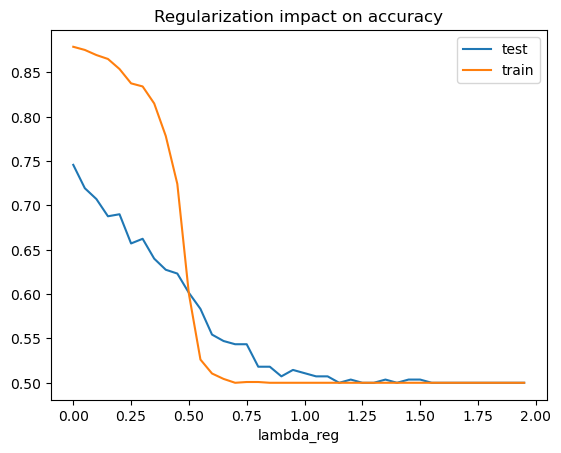

In [124]:
df.plot(x='lambda_reg', y=['test', 'train'], title='Regularization impact on accuracy')